### EDA for Open Shots Dataset

#### Packages and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load open shots dataset
open_shots_df = pd.read_csv('../data/clean/open_shot.csv')

#### Data Exploration

In [3]:
# Count the number of open/contested shots
open_shots_df['open_shot'].value_counts()

open_shot
1    69329
0    58740
Name: count, dtype: int64

Roughly 53% of shots are considered open/uncontested. This split with about half of the data means we won't run into issues with unbalanced datasets for later analysis and modeling.

/Users/rylee/Projects/Open-Shot/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rylee/Projects/Open-Shot/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rylee/Projects/Open-Shot/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rylee/Projects/Open-Shot/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

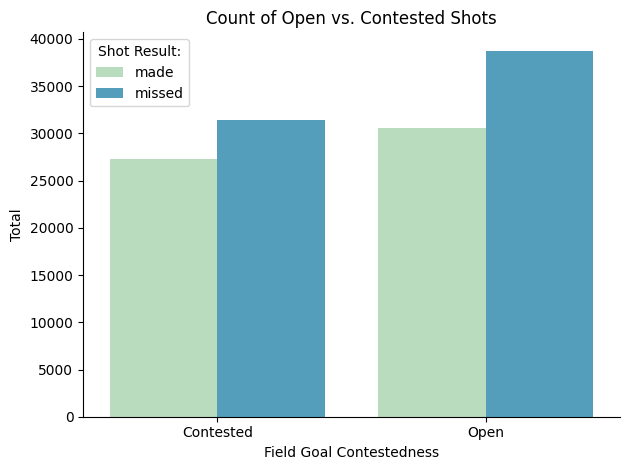

In [4]:
# Count plot of open vs. contested shots
sns.countplot(x="open_shot", hue="shot_result", data=open_shots_df, palette='GnBu')
plt.title('Count of Open vs. Contested Shots')
plt.xticks([0, 1], ['Contested', 'Open'])
plt.xlabel('Field Goal Contestedness')
plt.ylabel('Total')
plt.legend(title='Shot Result:', loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()

In [5]:
# Field goal percentage of open vs. contested shots
open_shots_df.groupby('open_shot').agg(
    fga=('fgm', 'count'),
    fgm=('fgm', 'sum')
).assign(
    fgpct=lambda x: x['fgm'] / x['fga']
)

,fga,fgm,fgpct
open_shot,,,
0,58740,27343,0.465492
1,69329,30562,0.440826


Upon initial exploration, the data is showing a counter-intuitive result: contested field goals are more likely to be made than uncontested shots. This result runs counter to expectations in basketball. This result is likely due to correlation issues between other variables in the dataset. The true effect of open looks on making shots will be revealed once controlling for other predictors.

/Users/rylee/Projects/Open-Shot/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rylee/Projects/Open-Shot/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


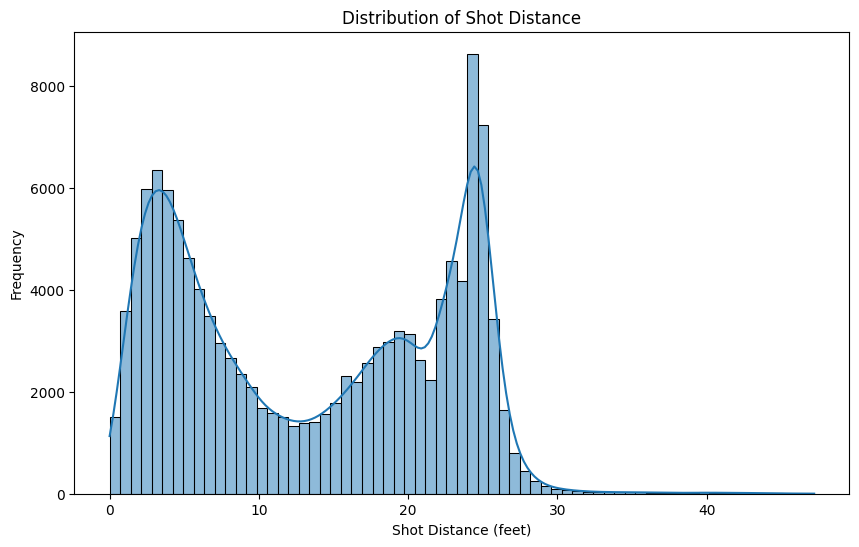

In [6]:
# Distribution of Shot Distance
plt.figure(figsize=(10, 6))
sns.histplot(open_shots_df['shot_dist'], kde=True)
plt.title('Distribution of Shot Distance')
plt.xlabel('Shot Distance (feet)')
plt.ylabel('Frequency')
plt.show()

Shot distance could be a confounding variable contributing to the results above. The distribution of shot distance follows expectations, where the highest number of shots are either close to the rim or beyond the three point line, the most efficient shots in basketball.

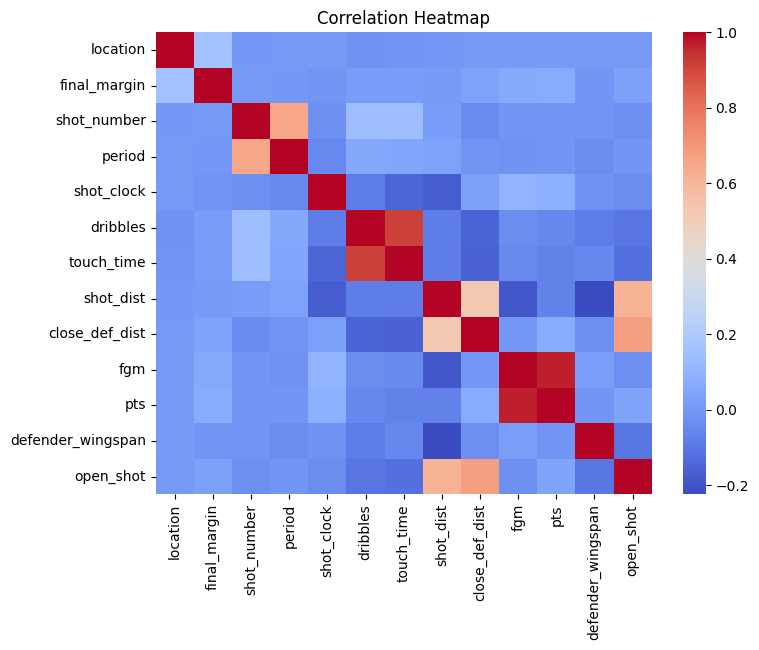

In [7]:
# Filtering dataset to the selected columns
selected_columns = ['location', 'final_margin', 'shot_number', 'period', 
                    'shot_clock', 'dribbles', 'touch_time', 'shot_dist', 
                    'close_def_dist', 'fgm', 'pts', 'defender_wingspan', 'open_shot']
filtered_df = open_shots_df[selected_columns].copy()
filtered_df['location'] = filtered_df['location'].apply(lambda x: 1 if x == 'H' else 0)

# Creating the correlation matrix
corr_matrix_filtered = filtered_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_filtered, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [8]:
# Columns with the highest correlation
t = corr_matrix_filtered.stack().reset_index()
t.columns = ['var1', 'var2', 'corr']
t = t[t['var1'] != t['var2']]
t = t.sort_values('corr', ascending=False, key=lambda x: x.abs())
t = t.reset_index(drop=True)
t = t.iloc[::2]
t.head(10)

,var1,var2,corr
0,pts,fgm,0.970686
2,touch_time,dribbles,0.914311
4,open_shot,close_def_dist,0.678413
6,period,shot_number,0.654932
8,open_shot,shot_dist,0.609218
10,shot_dist,close_def_dist,0.523192
12,shot_dist,defender_wingspan,-0.223925
14,shot_dist,fgm,-0.191704
16,shot_dist,shot_clock,-0.173026
18,close_def_dist,touch_time,-0.164737


Looking at the correlation between columns, there is some more evidence of correlation issues with the shot distance column. The open_shot dummy and shot distance have the fifth highest correlation of all columns (0.6046). Shots further away are more likely to be uncontested. However, increasing shot distance is negatively correlated with making field goals (-0.1917). This is likely the contributing factor to the backwards results with open shots seen earlier. A player is more likely to be open when taking a longer shot, but they are also less likely to make shots from further away.

The correlation matrix also shows some results that make intuitive sense. Players who have the ball longer during a touch tend to dribble more. For shots where a defender is further away, touches have a shorter average length. Shots taken further away from the basket tend to be more open, as noted above. One other interesting result is that shot distance is negatively correlated with the closest defender's wingspan. This is likely due to the fact that players who defend further away from the basket are typically guards, who are shorter on average.

In [9]:
filtered_df.describe()

,location,final_margin,shot_number,period,shot_clock,dribbles,touch_time,shot_dist,close_def_dist,fgm,pts,defender_wingspan,open_shot
count,128069.000000,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,0.499215,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,4.123015,0.452139,0.997314,83.019849,0.541341
std,0.500001,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,2.756446,0.497706,1.130978,4.075104,0.498290
min,0.000000,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,0.000000,0.000000,0.000000,70.750000,0.000000
25%,0.000000,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.300000,0.000000,0.000000,80.000000,0.000000
50%,0.000000,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,3.700000,0.000000,0.000000,83.250000,1.000000
75%,1.000000,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,5.300000,1.000000,2.000000,86.500000,1.000000
max,1.000000,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,53.200000,1.000000,3.000000,92.500000,1.000000


In [10]:
# Field goal attempts and percent by shot type
open_shots_df.groupby('pts_type').agg(
    fga=('fgm', 'count'),
    fgm=('fgm', 'sum')
).assign(
    fgpct=lambda x: x['fgm'] / x['fga']
)

,fga,fgm,fgpct
pts_type,,,
2,94173,45990,0.488357
3,33896,11915,0.351516


In [11]:
# Field goal percent by shot type and contestedness
open_shots_df.groupby(['pts_type', 'open_shot']).agg(
    fga=('fgm', 'count'),
    fgm=('fgm', 'sum')
).assign(
    fgpct=lambda x: x['fgm'] / x['fga']
)

fga    fgm     fgpct
pts_type open_shot                        
2        0          55105  26342  0.478033
         1          39068  19648  0.502918
3        0           3635   1001  0.275378
         1          30261  10914  0.360662

The final two tables show the number of field goal attempts and percent made in different scenarios. The first breaks it down by the shot type, either 2s or 3s. This produces the expected result where 2-point shots are made more efficiently than 3-point attempts. About 49% of 2's are made, while only 35% of 3's are, in line with historic league averages.

The second table shows a more interesting result: after controlling for the type of shot, open looks are made at a higher rate than contested shots. This is a simple way of controlling for shot distance and produces the desired results. This shows that the counter-intuitive result from above where open shots are less likely to be made than contested shots was due to confounding effects with shot distance.

#### Missing Values

In [12]:
# Count missing values by column
open_shots_df.isnull().sum()

game_id                   0
matchup                   0
location                  0
win                       0
final_margin              0
shot_number               0
period                    0
game_clock                0
shot_clock             5567
dribbles                  0
touch_time                0
shot_dist                 0
pts_type                  0
shot_result               0
closest_defender          0
closest_defender_id       0
close_def_dist            0
fgm                       0
pts                       0
player_name               0
player_id                 0
defender_wingspan         0
close_def_dist_in         0
open_shot                 0
dtype: int64

In [13]:
# Show 10 rows where shot clock is missing
open_shots_df[open_shots_df['shot_clock'].isnull()].head()

,game_id,matchup,location,win,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,closest_defender,closest_defender_id,close_def_dist,fgm,pts,player_name,player_id,defender_wingspan,close_def_dist_in,open_shot
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,82.76,10.8,0
24,21400845,"FEB 25, 2015 - CHA @ CHI",A,W,12,6,2,0:04,NaN,0,...,"Butler, Jimmy",202710,3.6,0,0,brian roberts,203148,79.50,43.2,1
54,21400768,"FEB 08, 2015 - CHA vs. IND",H,L,-1,14,4,0:01,NaN,5,...,"Hill, George",201588,3.6,0,0,brian roberts,203148,81.00,43.2,1
76,21400742,"FEB 05, 2015 - CHA vs. WAS",H,W,7,10,3,0:01,NaN,2,...,"Butler, Rasual",2446,2.5,1,2,brian roberts,203148,84.00,30.0,0
129,21400611,"JAN 19, 2015 - CHA vs. MIN",H,W,25,7,2,0:02,NaN,5,...,"Williams, Mo",2590,4.0,0,0,brian roberts,203148,77.50,48.0,1


Because we already handled missing data for wingspans when creating the dataset, the only column with missing data is the shot clock column. Upon inspection of rows with missing shot clock values, these seem to be instances where the shot clock if 'off'. These are scenarios where the game clock is less than 24 seconds, meaning the shot clock is not needed. Accordingly, these shot clock values are not missing, because there is no shot clock in these instances.

As a result, no steps are needed to handle missing data in the EDA process. When developing the predictive models in the future, some steps may be needed to account for when the shot clock is off, but that can be handled during feature engineering rather than EDA.

Note: Generative AI was used to complete this notebook.